In [1]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# sns.set_style({'font.family':'sans-serif', 'font.sans-serif':'Arial'})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
wes_file = "/data5/deepro/ukbiobank/papers/bmi_project/2_prepare_data_for_analysis/obesity_related_diseases/data/tables/wes.tsv"
intersect_file = "/data5/deepro/ukbiobank/papers/bmi_project/4_characterization/obesity_related_diseases/data/upset_files/protection_intersects.json"
combos_file = "/data5/deepro/ukbiobank/papers/bmi_project/4_characterization/obesity_related_diseases/data/merged_combos/protective_combos.csv"
selected_samples_file = "/data5/deepro/ukbiobank/papers/bmi_project/2_prepare_data_for_analysis/white_british/data/cases_controls/cases.txt"
icd_cases_dir = "/data5/deepro/ukbiobank/papers/bmi_project/2_prepare_data_for_analysis/obesity_related_diseases/data/cases_controls"
gencode_file = '/data5/bx_reference/hg38/annotations/gene_annotations/GENCODE39/gencode.v39.parsed.genes.tsv'
icd_names_file = "/data5/deepro/ukbiobank/papers/bmi_project/2_prepare_data_for_analysis/obesity_related_diseases/data/tables/obesity_related_diseases_icd.csv"

In [3]:
def read_intersects_file(json_file):
    with open(json_file, "r") as f:
        json_object = json.load(f)
    return json_object

def get_all_unique_genes_combos_from_intersect_dict(intersect_dict):
    unique_combos = set(sum(list(map(lambda x: x.split("||"), list(intersect_dict.values()))), []))
    unique_genes = set(sum(list(map(lambda x: x.split("_"), unique_combos)), []))
    return unique_genes, unique_combos

def read_wes_file(wes_file, unique_genes):
    cols_to_use = [f"Input_{gid}" for gid in unique_genes] + ["Sample_Name"]
    wes_df = pd.read_csv(wes_file, sep="\t",  low_memory=False, index_col=0, usecols=cols_to_use)
    return wes_df

def read_selected_samples_file(samples_file):
    with open(samples_file, "r") as f:
        samples = [int(l.strip()) for l in f.readlines()]
    return samples

def get_all_unique_icd_from_intersect_dict(intersect_dict):
    unique_icds_combos = set(list(map(lambda x: x.split("||")[0], list(intersect_dict.keys()))))
    unique_icds = set(sum(list(map(lambda x: x.split(","), unique_icds_combos)), []))
    return unique_icds

def get_gencode_dict(gencode_file):
    gencode = pd.read_csv(gencode_file, sep='\t', low_memory=False)
    gencode["gene_id_stripped"] = gencode["gene_id"].str.split(".", expand=True)[0]
    gene_symbol_dict = dict(zip(gencode.gene_id_stripped, gencode.gene_name))
    return gene_symbol_dict

def get_icd_dict(icd_names_file):
    icd_names = pd.read_csv(icd_names_file)
    icd_names_dict = {c.replace(" ", ""): m for c,m in zip(icd_names.coding, icd_names.meaning)}
    return icd_names_dict

def edit_profile_df_colnames(colnames, gene_symbol_dict, icd_symbol_dict):
    new_gene_cols = []
    new_icd_cols = []
    new_colnames = []
    for c in colnames:
        if c.startswith("Input_ENSG"):
            item_name = gene_symbol_dict[c.replace("Input_", "")]
            new_gene_cols.append(item_name)
        else:
            if c != "Obesity_risk":
                item_name = icd_symbol_dict[c]
                new_icd_cols.append(item_name)
            else:
                item_name = c
        new_colnames.append(item_name)
    return new_colnames, new_gene_cols, new_icd_cols
    

In [4]:
# read only the obese samples
samples =  read_selected_samples_file(selected_samples_file)
# read the icd protection intersecting gene combo dict
intersect_dict = read_intersects_file(intersect_file)
# filter the intersect dict to keep only samples who are protected for 3 icd codes
intersect_dict = {k:v for k,v in intersect_dict.items() if len(k.split("||")[0].split(","))>2}
unique_genes, unique_combos = get_all_unique_genes_combos_from_intersect_dict(intersect_dict)
# read the wes profile of obese individuals
wes_df = read_wes_file(wes_file, unique_genes)
selected_wes_df = wes_df.loc[wes_df.index.isin(samples)]
# only keep those individuals who have the combo
cond = " | ".join(["(" + " & ".join([f"(Input_{c} == 1)" for c in ec_i]) + ")" for ec_i in list(map(lambda x: x.split("_"), unique_combos))])
profile_df = selected_wes_df.loc[selected_wes_df.eval(cond)]
# add their obeisty risk profile
profile_df["Obesity_risk"] = 1
# get the unique icd codes from the intersect dict
unique_icds = get_all_unique_icd_from_intersect_dict(intersect_dict)
# add the icd profile of these individuals
for icd in unique_icds:
    profile_df[icd] = 0
    icd_case_file = os.path.join(icd_cases_dir, f"cases_{icd}.txt")
    case_samples_icd = read_selected_samples_file(icd_case_file)
    profile_df.loc[profile_df.index.isin(case_samples_icd), icd] = 1
# make a list of the gene and icd columns
gene_cols = [c for c in profile_df.columns if c.startswith("Input_")]
icd_cols = [c for c in profile_df.columns if not c.startswith("Input_")]
# edit the profile df columns so that it makes more sense
gene_symbol_dict = get_gencode_dict(gencode_file)
icd_names_dict = get_icd_dict(icd_names_file)
profile_df.columns, ngene_cols, nicd_cols =  edit_profile_df_colnames(profile_df.columns, gene_symbol_dict, icd_names_dict)


/tmp/ipykernel_2243033/1442892156.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile_df["Obesity_risk"] = 1
/tmp/ipykernel_2243033/1442892156.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile_df[icd] = 0
/data5/deepro/miniconda3/envs/starrseq/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [24]:
profile_pivot = profile_df.pivot_table(index=ngene_cols+nicd_cols, aggfunc=np.sum).reset_index()

In [25]:
profile_pivot_selected = profile_pivot.loc[profile_pivot.Obesity_risk>1]

In [54]:
gene_symbol_dict["ENSG00000068976"]

'PYGM'

In [52]:
gene_cols

['Input_ENSG00000007520',
 'Input_ENSG00000068976',
 'Input_ENSG00000115365',
 'Input_ENSG00000117266',
 'Input_ENSG00000131584',
 'Input_ENSG00000133056',
 'Input_ENSG00000167967',
 'Input_ENSG00000168530',
 'Input_ENSG00000169962',
 'Input_ENSG00000171401',
 'Input_ENSG00000171431',
 'Input_ENSG00000186185',
 'Input_ENSG00000196557',
 'Input_ENSG00000197136',
 'Input_ENSG00000204889',
 'Input_ENSG00000260027']

In [51]:
ngene_cols

['TSR3',
 'PYGM',
 'LANCL1',
 'CDK18',
 'ACAP3',
 'PIK3C2B',
 'E4F1',
 'MYL1',
 'TAS1R3',
 'KRT13',
 'KRT20',
 'KIF18B',
 'CACNA1H',
 'PCNX3',
 'KRT40',
 'HOXB7']

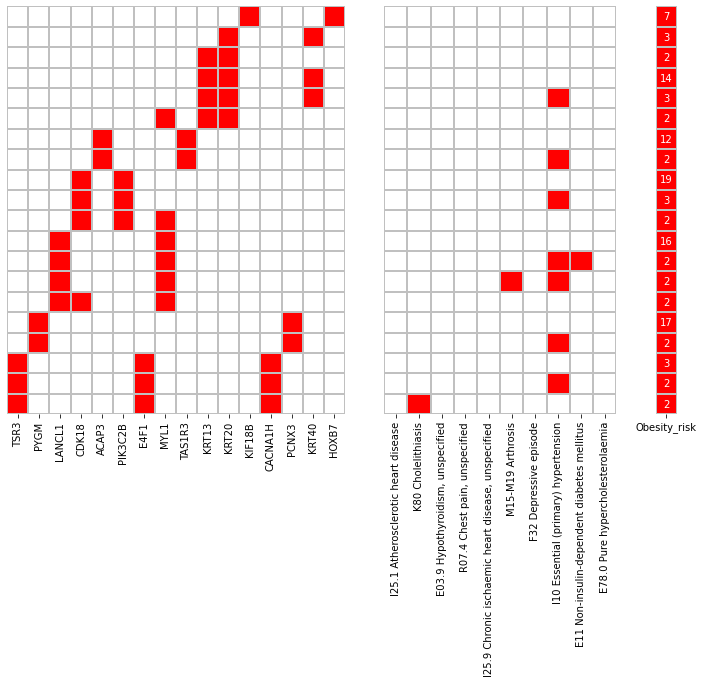

In [49]:
fig, ax = plt.subplots(1,3, figsize=(12, 7.5), gridspec_kw={'width_ratios': [len(gene_cols), len(icd_cols), 1]})
g1 = sns.heatmap(
    data=profile_pivot_selected.loc[:, ngene_cols], 
    linewidths=1.5,
    linecolor="silver", 
    cbar=False,
    cmap=["w", "r"],
    ax=ax[0],
    yticklabels=False,
    square=False,
    )
g2 = sns.heatmap(
    data=profile_pivot_selected.loc[:, nicd_cols], 
    linewidths=1.5,
    linecolor="silver", 
    cbar=False,
    cmap=["w", "r"],
    ax=ax[1],
    yticklabels=False,
    square=False,
    )

g3 = sns.heatmap(
    data=(profile_pivot_selected.loc[:, "Obesity_risk"]>0).to_frame(), 
    linewidths=1.5,
    linecolor="silver", 
    cbar=False,
    cmap=["r"],
    ax=ax[2],
    annot=profile_pivot_selected.loc[:, "Obesity_risk"].to_frame(),
    yticklabels=False,
    square=False,
    )

In [58]:
icd_names_dict["I259"]

'I25.9 Chronic ischaemic heart disease, unspecified'